# Part 0:
## import everything
Run the cell below

In [ ]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
import sys
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
from scipy import stats
from scipy.ndimage.filters import gaussian_filter as smooth
import matplotlib.animation as animation
import matplotlib.backends.backend_pdf
import mpl_toolkits.axes_grid1.inset_locator as inset
from matplotlib.ticker import FormatStrFormatter, MaxNLocator, ScalarFormatter, FuncFormatter
from matplotlib.patches import ConnectionPatch, FancyArrowPatch
from set_rc_params import set_rc_params
import ROOT


if "__file__" not in dir():
    %matplotlib inline
    %config InlineBackend.close_figures = False

    root=ROOT.root
    
    ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
    CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
    CWD=os.getcwd()
    os.chdir(CommonNoteBookesPath)
    %run UtilityTools.ipynb
    %run Animal_Tags.ipynb
    %run loadRat_documentation.ipynb
    %run Lesion_Size.ipynb
    %run plotRat_documentation_1_GeneralBehavior.ipynb
    %run plotRat_documentation_3_KinematicsInvestigation.ipynb
    %run RunBatchRat_3_CompareGroups.ipynb
    %run BatchRatBehavior.ipynb
    currentNbPath=os.path.join(os.path.split(ThisNoteBookPath)[0],'LesionPaper','MaxPosAnalysis.ipynb')
    %run $currentNbPath

    os.chdir(CWD)

    logging.getLogger().setLevel(logging.ERROR)
    
    param={
        "goalTime":7,#needed for pavel data only
        "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
        "maxTrialDuration":15,
        "interTrialDuration":10,#None pavel
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "cameraSamplingRate":25, #needed for new setup    

        "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
        "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
        "nbJumpMax":100,#200 pavel
        "binSize":0.25,
        #parameters used to preprocess (will override the default parameters)
    }
    Y1,Y2=param['treadmillRange']

    print('os:',OS(),'\nroot:',root,'\nImport successful!')

---
---


# part 1:

# DEFINITIONS

### If you don't know what to do, move to part 2

---

String Format for Scientific Notation

In [ ]:
def SciNote(string):
    """
    Format numbers with Real scientific notation
    Ex: 'p-val={}'.format(SciNote(p))
    """
    f = ScalarFormatter(useOffset=False, useMathText=True)
    g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.2e' % x))
    fmt = FuncFormatter(g)
    return fmt(string)

---

plotting group double errorbars for speed 

In [ ]:
def plot_event_1on1(root, ax, Profiles, colorCode, badAnimals=None, TaskParamToPlot='% good trials',
                   x_pos=None, nPre=slice(-3,None), nPost=slice(0,3),nFin=slice(3,6),
                    seed=1, animal_plot=True):
    if badAnimals is None:
        badAnimals=[]
    
    if x_pos is None:
        diff=.35
        x_c=ax.get_xlim()[1]
        x_pos=(x_c-diff,x_c+diff,x_c+3*diff)
    diff=x_pos[1]-x_pos[0]
    
    #getting the data
    animalList,sessionDict=event_detect(root, Profiles[0], Profiles[1], badAnimals=badAnimals)
    
    data=np.empty((len(animalList),3))
    for i,animal in enumerate(animalList):
        preSession,postSession=sessionDict[animal][0], sessionDict[animal][1]
        out=animal_learning_stats(root, animal, PerfParam=TaskParamToPlot,
                                  goodSessions=[*preSession,*postSession],redo=False)
        
        data[i,0]=np.nanmedian(out[:len(preSession)][nPre])
        data[i,1]=np.nanmedian(out[len(preSession):][nPost])
        data[i,2]=np.nanmedian(out[len(preSession):][nFin])
        
            
    
    y=np.nanpercentile(data,50,axis=0)
    yerr=np.nanpercentile(data,(25,75),axis=0)
    
    #plotting the errorbar
    ax.errorbar(x_pos, y, abs(yerr-y),fmt='o', zorder=5, ms=2, elinewidth=1, color='k')
    
    #plotting individual animals
    if animal_plot:
        np.random.seed(seed=seed)
        _coeff=50000
        for i in range(data.shape[0]):
            if np.any(np.isnan(data[i,:])):
                continue
            jitPre =np.random.uniform(low=x_pos[0]-diff/_coeff, high=x_pos[0]+diff/_coeff, size=1)
            jitPost=np.random.uniform(low=x_pos[1]-diff/_coeff, high=x_pos[1]+diff/_coeff, size=1)
            jitFin =np.random.uniform(low=x_pos[2]-diff/_coeff, high=x_pos[2]+diff/_coeff, size=1)
            
            _,tag=lesion_type(root,animalList[i])
            c=colorCode[tag] if tag in colorCode else 'gray'
            ax.scatter([jitPre,jitFin],data[i,[0,-1]], s=1, c=c, marker='o', edgecolors='none', alpha=.8)
#             ax.plot([jitPre,jitPost,jitFin],data[i,:], c=c, lw=.2, alpha=.4)
            ax.plot([jitPre,jitFin],data[i,[0,-1]], c=c, lw=.2, alpha=.4)

    ax.set_xlim([x_pos[0]-diff/2,x_pos[-1]+diff/2])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Before','Acute','Stable'])
    ax.xaxis.set_tick_params(rotation=0)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(TaskParamToPlot)
    ax.set_xlabel('Sessions relative to lesion')

    return data,animalList

In [ ]:
if "__file__" not in dir():

    profile1={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Control', 'Control-AfterBreak', 'Control-Late-NoTimeout-BackToTimeout',
              'Control-NoTimeout-Control','Control-Sharp','IncReward-Late-Sharp',
              'Control-Sharp-AfterBreak','ImmobileTreadmill-Control']
             }
    profile2={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Late-Lesion_DLS','Late-Lesion_DMS','Late-Lesion_DS',
                    'Late-Lesion_DS-Sharp','Late-Lesion_DMS-Sharp']
             }

    #number of sessions to plot
    badAnimals=['RatBAD']
    TaskParamToPlot="% good trials"
    wspace=0.05
    
    
    Profiles=(profile1,profile2,)
    plt.close('all')
    fig=plt.figure(figsize=(5,4))
    ax=fig.add_subplot(111)

    ax.set_xticks([])
    plot_event_1on1(root, ax, Profiles, colorCode={'Control':'r'}, badAnimals=None, TaskParamToPlot=TaskParamToPlot,
                       x_pos=None, nPre=slice(-3,None), nPost=slice(0,3),nFin=slice(3,6),
                        seed=1, animal_plot=True)

---

plot the speed correlation plot

In [ ]:
def _late_lesion_effect(root, Profiles, badAnimals, TaskParamToPlot:str,
                        preSlice=slice(-5,None), postSlice=slice(0,5)):
    
    _,sessionDict=event_detect(root, Profiles[0], Profiles[1], badAnimals=badAnimals)
    [sessionDict.pop(key, None) for key in badAnimals]
    
    Results,nSessionPre,nSessionPost=event_statistic2(root,
                                                 sessionDict,
                                                 parameter=param,
                                                 redo=False,
                                                 TaskParamToPlot=[TaskParamToPlot])

    data=np.array(list(Results[TaskParamToPlot].values()))
    slicedPreData  = np.ones((data.shape))*np.nan
    slicedPostData = np.ones((data.shape))*np.nan
    
    for row,Dnan in enumerate(data):
        Dpre= Dnan[:nSessionPre]#[~ np.isnan(Dnan[:nSessionPre])]
        Dpost=Dnan[nSessionPre:]#[~ np.isnan(Dnan[nSessionPre:])]
        preData =Dpre[preSlice]
        postData=Dpost[postSlice]

        slicedPreData[row,:len(preData)]=preData
        slicedPostData[row,:len(postData)]=postData
    
    yPre =np.nanmean(slicedPreData ,axis=1)
    yPost=np.nanmean(slicedPostData,axis=1)

    behav=[]
    animals=[]
    for i,animal in enumerate(Results[TaskParamToPlot].keys()):
        if np.isnan(yPre[i]) or np.isnan(yPost[i]):
            logging.error(f'{animal}: {TaskParamToPlot} not defined!')
            continue

        behav.append(yPost[i]-yPre[i])
        animals.append(animal)
    
    return behav, animals

def late_lesion_correlation_with_size(root, ax, Profiles, Animals, color, TaskParamToPlot:str,
                                      preSlice=slice(-5,None), postSlice=slice(0,5)):
    
    _,sessionDict=event_detect(root, Profiles[0], Profiles[1])
    
    sessionDict={animal:sessionDict[animal] for animal in Animals}
    
    Results,nSessionPre,nSessionPost=event_statistic2(root,
                                                 sessionDict,
                                                 parameter=param,
                                                 redo=False,
                                                 TaskParamToPlot=[TaskParamToPlot])

    data=np.array(list(Results[TaskParamToPlot].values()))
    slicedPreData  = np.ones((data.shape))*np.nan
    slicedPostData = np.ones((data.shape))*np.nan
    
    for row,Dnan in enumerate(data):
        Dpre= Dnan[:nSessionPre]#[~ np.isnan(Dnan[:nSessionPre])]
        Dpost=Dnan[nSessionPre:]#[~ np.isnan(Dnan[nSessionPre:])]
        preData =Dpre[preSlice]
        postData=Dpost[postSlice]

        slicedPreData[row,:len(preData)]=preData
        slicedPostData[row,:len(postData)]=postData
    
    yPre =np.nanmean(slicedPreData ,axis=1)
    yPost=np.nanmean(slicedPostData,axis=1)

    size=[]
    behav=[]
    animals=[]
    for i,animal in enumerate(Results[TaskParamToPlot].keys()):
        if np.isnan(yPre[i]) or np.isnan(yPost[i]):
            logging.error(f'{animal}: {TaskParamToPlot} not defined!')
            continue
        try:
            Hist=HistologyExcel('/NAS02',animal)
        except Exception as e:
            logging.error(f'{animal}: {repr(e)}')
            continue
        
        behav.append(yPost[i]-yPre[i])
        size.append(Hist.lesion_size())
        animals.append(animal)
        
    
    #plotting
    if ax is not None:
        for i,animal in enumerate(animals):
            _,tag=lesion_type(root,animal)
            ax.scatter(size[i], behav[i], s=4, c=color[tag], label=tag);
#             ax.annotate(animal[-3:], (size[i],behav[i]), fontsize='xx-small')

        ax.set_xticks(np.arange(0,1.01,.1))
        ax.set_xticklabels(['0','','','','','0.5','','','','','1'])
        ax.spines['bottom'].set_bounds(0,1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim([-.02,1.02])
        ax.set_ylabel(f'$\Delta$ {TaskParamToPlot}')
        ax.set_xlabel('Lesion size')

    
    return behav, size, animals

In [ ]:
if "__file__" not in dir():

    profile1={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Control', 'Control-AfterBreak', 'Control-Late-NoTimeout-BackToTimeout',
              'Control-NoTimeout-Control','Control-Sharp','IncReward-Late-Sharp',
              'Control-Sharp-AfterBreak','ImmobileTreadmill-Control']
             }
    profile2={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Late-Lesion_DLS','Late-Lesion_DMS','Late-Lesion_DS',
                    'Late-Lesion_DS-Sharp','Late-Lesion_DMS-Sharp']
             }

    Profiles=(profile1,profile2)
    TaskParamToPlot="Forward Running Speed"
    preSlice=slice(-5,None)
    postSlice=slice(3,8)
    
    color={'DS':'r','DMS':'g', 'DLS':'b', 'Control':'k'}
    
    plt.close('all')
    ax=plt.subplot(111)

    
#     a=late_lesion_correlation_with_size(root, ax=ax, Profiles=Profiles,color=color, TaskParamToPlot=TaskParamToPlot,
#                                       preSlice=preSlice, postSlice=postSlice)

---

Max Pos Comparison for Animals with Speed Effect

In [ ]:
def plot_event_with_animalList(root, ax, Profiles, colorCode, animalList, TaskParamToPlot="Maximum Position",
                   x_pos=None, nPre=slice(-3,None), nPost=slice(0,3),nFin=slice(3,6),
                    seed=1, animal_plot=True):
    
    if x_pos is None:
        diff=.35
        x_c=ax.get_xlim()[1]
        x_pos=(x_c-diff,x_c+diff,x_c+3*diff)
    diff=x_pos[1]-x_pos[0]
    
    #getting the data
    _,sessionDict=event_detect(root, Profiles[0], Profiles[1])
    
    data=np.ones((len(animalList),3))*np.nan
    for i,animal in enumerate(animalList):
        if animal not in sessionDict:
            logging.warning ("Animals don't match the Profiles!")
            continue
        preSession,postSession=sessionDict[animal][0], sessionDict[animal][1]
        out=animal_learning_stats(root, animal, PerfParam=TaskParamToPlot,
                                  goodSessions=[*preSession,*postSession],redo=False)
        
        data[i,0]=np.nanmedian(out[:len(preSession)][nPre])
        data[i,1]=np.nanmedian(out[len(preSession):][nPost])
        data[i,2]=np.nanmedian(out[len(preSession):][nFin])
            
    
    y=np.nanpercentile(data,50,axis=0)
    yerr=np.nanpercentile(data,(25,75),axis=0)
    
    #plotting the errorbar
    ax.errorbar(x_pos, y, abs(yerr-y),fmt='o', zorder=5, ms=2, elinewidth=1, color='k')
    
    #plotting individual animals
    if animal_plot:
        np.random.seed(seed=seed)
        _coeff=50000
        for i in range(data.shape[0]):
            if np.any(np.isnan(data[i,[0,-1]])):
                continue
            jitPre =np.random.uniform(low=x_pos[0]-diff/_coeff, high=x_pos[0]+diff/_coeff, size=1)
            jitPost=np.random.uniform(low=x_pos[1]-diff/_coeff, high=x_pos[1]+diff/_coeff, size=1)
            jitFin =np.random.uniform(low=x_pos[2]-diff/_coeff, high=x_pos[2]+diff/_coeff, size=1)
            
            _,tag=lesion_type(root,animalList[i])
            c=colorCode[tag] if tag in colorCode else 'gray'
            ax.scatter([jitPre,jitFin],data[i,[0,-1]], s=1, c=c, marker='o', edgecolors='none', alpha=.8)
#             ax.plot([jitPre,jitPost,jitFin],data[i,:], c=c, lw=.2, alpha=.4)
            ax.plot([jitPre,jitFin],data[i,[0,-1]], c=c, lw=.2, alpha=.4)

    ax.set_xlim([x_pos[0]-diff/2,x_pos[-1]+diff/2])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Before','Acute','Stable'])
    ax.xaxis.set_tick_params(rotation=0)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(TaskParamToPlot)
    ax.set_xlabel('Sessions relative to lesion')

    return data

In [ ]:
if "__file__" not in dir():

    profile1={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Control', 'Control-AfterBreak', 'Control-Late-NoTimeout-BackToTimeout',
              'Control-NoTimeout-Control','Control-Sharp','IncReward-Late-Sharp',
              'Control-Sharp-AfterBreak','ImmobileTreadmill-Control']
             }
    profile2={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Late-Lesion_DLS','Late-Lesion_DMS','Late-Lesion_DS',
                    'Late-Lesion_DS-Sharp','Late-Lesion_DMS-Sharp']
             }

    #number of sessions to plot   
    
    Profiles=(profile1,profile2,)
    plt.close('all')
    fig=plt.figure(figsize=(5,4))
    ax=fig.add_subplot(111)

    behav, size, animals=late_lesion_correlation_with_size(root, ax=ax, Profiles=Profiles, badAnimals=[],
                                                              color=ColorCode,
                                                              TaskParamToPlot="Forward Running Speed")

    plt.close('all')
    fig=plt.figure(figsize=(5,4))
    ax=fig.add_subplot(111)
    
    animalList=[animal for i,animal in enumerate(animals) if behav[i]<0]
    d,a=plot_event_with_animalList(root, ax, Profiles, colorCode={'Control':'r'}, animalList=animalList,
                                  nPre=slice(-3,None), nPost=slice(0,3),nFin=slice(3,6))


---

Plot Traj of EX sessions

In [ ]:
def plot_session_median_trajectory(data,ax,trialToPlot):
    posDict=data.position
    maxL=np.nanmax(list(data.stopFrame.values()))
    maxL=int(maxL)
    position=np.ones((maxL,len(trialToPlot)))*np.nan
    time=np.arange(-data.cameraToTreadmillDelay,
                   (maxL-data.cameraSamplingRate)/data.cameraSamplingRate,
                   1/data.cameraSamplingRate)
    
    i=0
    for trial in posDict:
        if trial not in trialToPlot:
            continue
        pos=posDict[trial][:data.stopFrame[trial]]
        position[:len(pos),i]=pos
        i+=1
    
    #keeping data where 70% of points exist
    nanSum=np.sum(np.isnan(position),axis=1)
    try:
        maxTraj=np.where(nanSum>.3*position.shape[1])[0][0]
    except IndexError:
        maxTraj=position.shape[1]
    
    
    ax.plot(time[:maxTraj], np.nanmean(position,axis=1)[:maxTraj], color='navy', lw=2, zorder=10)
    
    return np.nanmean(position,axis=1)[:maxTraj]

def plot_trajectories(data,ax):
    posDict=data.position
    time=data.timeTreadmill #align on camera
    
    _,hardR,_=sequentialTrials(data)._compute_max_pos()
    
    Colors=[]
    for trial in posDict:
        color="xkcd:green"
        zorder=1
        alpha=1
        if trial not in hardR:
            color="salmon"
            zorder=0
            alpha=.2
        Colors.append(color)
        ax.plot(time[trial][:data.stopFrame[trial]], posDict[trial][:data.stopFrame[trial]],
               color=color, lw=.5, zorder=zorder, alpha=alpha)
            
#     ax.fill_betweenx(y=(0,90),x1=0,x2=7, facecolor='gray', edgecolor=None, alpha=.4)
    
    return np.array(Colors),hardR



def plot_trajectories_and_distributions(root, ax, session):
    data=Data(root,session[:6],session,redoPreprocess=False)
    
    color,hardR=plot_trajectories(data,ax=ax)
    
    position=get_positions_array_beginning(data,onlyGood=False,raw=False)
    position=position.T
    
    mean_traj=plot_session_median_trajectory(data,ax,hardR)
    
    
    ax.set_xlim([-1.2,11.2])
    ax.set_ylim([-2,90])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(bottom=False, top=False, left=False, right=False,
                  labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    
    return mean_traj

In [ ]:
if "__file__" not in dir():
    session='Rat302_2019_01_14_14_27'

    plt.close('all')
    ax=plt.figure(figsize=(3,3)).add_subplot(111);

    plot_trajectories_and_distributions(root, ax, session)

---

plotting the predefined image

In [ ]:
def plot_animal_image(ax, animal):
    PATHS=('/NAS02/Rat302/Histology/DS_45.jpg',)
    
    try:
        filePath=[path for path in PATHS if animal in path][0]
    except IndexError:
        logging.error(f'Bad Animal name ({animal}), path not defined!')
        return
    
    f=PIL.Image.open(filePath)
    f.thumbnail((500,500),PIL.Image.ANTIALIAS)
    ax.imshow(f)

---

plotting group time course

In [ ]:
def normalize_performance(a,nPre):
    """implement a normalizing function to operate on 'a' and nPre first point are baseline
       a: np.array: animal x session
    """
    meanBase= np.nanmedian(a[:,:nPre], axis=1, keepdims=True)
    
    out=a-meanBase
    return out

def plot_normalized_time_course(root, ax, Profiles, Animals=None, TaskParamToPlot='% good trials', shift=0,
                   nPre=5, nPost=15, **kwarg):

    #getting the data
    animalList,SessionDict=event_detect(root, Profiles[0], Profiles[1])
    
    if Animals is None:
        Animals=animalList
    
    SessionDict={animal:SessionDict[animal] for animal in Animals}
    Results,nSessionPre,nSessionPost=event_statistic2(root,
                                                      SessionDict,
                                                      parameter=param,
                                                      redo=False,
                                                      TaskParamToPlot=[TaskParamToPlot])
    
    assert nPre<=nSessionPre and nPost<=nSessionPost,"fewer sessions available than requested:"
    
    data=np.array(list(Results[TaskParamToPlot].values()))
    
    xData=np.append(np.arange(-nPre,0),np.arange(1,nPost+1))
    data=data[:,nSessionPre-nPre:nSessionPre+nPost]
    
    data=normalize_performance(data,nPre)
    
    reliableAnimals=np.sum(np.isnan(data),axis=1) < data.shape[1] / 2
    
    data=data[reliableAnimals,:]
    animalList=np.array(list(Results[TaskParamToPlot].keys()))[reliableAnimals]
    
    groupData=np.nanmedian(data,axis=0)
    
    groupErr=np.nanpercentile(data,(25,75),axis=0)
    
    #plotting the errorbar
    ax.errorbar(xData + shift, groupData,
                abs(groupErr-groupData),
                fmt='-o', zorder=5, ms=2, elinewidth=1,alpha=.8, **kwarg)
    
    ax.axhline(0, ls=':',c='gray',lw=1)
    
    def _tik(x,pos):
        if x in [-nPre,-1,1,nPost]:
            return ('%+g' if x>0 else '%g')%x
        else:
            return ''
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(_tik))
    
    ax.set_xlim([-nPre-.3,nPost+.3])
    ax.spines['bottom'].set_bounds(-nPre,nPost)
    ax.set_xticks(xData)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#     ax.set_ylim([0,100])
    ax.set_ylabel('Norm. '+TaskParamToPlot)
    ax.set_xlabel('Sessions # relative to lesion')

    return data,animalList


In [ ]:
if "__file__" not in dir():

    profile1={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':['10','0'],
              'Speed':'10',
              'Tag':['Control', 'Control-AfterBreak', 'Control-Late-NoTimeout-BackToTimeout', 'Control-NoTimeout-Control',
                     'Control-Sharp','IncReward-Late-Sharp','Control-Sharp-AfterBreak','ImmobileTreadmill-Control']
              }
    profile2={'Type': ['Good'],
             'rewardType': ['Progressive'],
             'option': ['not used', 'AsymmetricLesion'],
             'initialSpeed': ['0', '10'],
             'Speed': ['10'],
             'Tag': ['Late-Lesion_DLS',
              'Late-Lesion_DMS-Sharp',
              'Late-Lesion_DMS',
              'Late-Lesion_DS',
              'Late-Lesion_DS-Sharp']}

    #number of sessions to plot
    animalList,_=event_detect(root,profile1,profile2)
    TaskParamToPlot="Forward Running Speed"
    wspace=0.05
    
    
    Profiles=(profile1,profile2,)
    plt.close('all')
    fig=plt.figure(figsize=(5,4))
    ax=fig.add_subplot(111)

    a=plot_normalized_time_course(root, ax, Profiles,Animals=animalList,TaskParamToPlot=TaskParamToPlot,color='k',shift=-.1*.25)
#     ax.set_ylim([0,100])

---

plotting group lesion size

In [ ]:
def plot_group_lesion_bar(animalList, ax=None, x=0, color='k'):
    _W=.8   #bar width
    lesionsize=[]
    for animal in animalList:
        try:
            tmp=HistologyExcel('/NAS02',animal).lesion_size()
        except:
            tmp=np.nan
        finally:
            lesionsize.append(tmp)
    
    if ax is not None:
        ax.bar(x,np.nanmedian(lesionsize), ec=None, fc=color, zorder=1)
        
        _coeff=2
        x_vals=np.random.uniform(low=x-_W/_coeff, high=x+_W/_coeff, size=len(animalList))
        ax.scatter(x_vals, lesionsize, s=3, c='xkcd:red', marker='o', edgecolors='none', alpha=.8, zorder=2)
        np.random.seed(seed=3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xlim([x-_W,x+_W])
        ax.set_xticks([x])
        
    return np.array(lesionsize)

In [ ]:
if "__file__" not in dir():
    plt.close('all')
    fig=plt.figure(figsize=(5,4))
    ax=fig.add_subplot(111)

    plot_group_lesion_bar(['Rat304','Rat302','Rat079'],ax=ax)

------



------

# part 2:

# GENERATING THE FIGURE

Definition of Parameters

In [ ]:
if "__file__" not in dir():
    # GENERAL PARAMS
    
    CtrlColor='gray'
    DLSColor='xkcd:red'
    DMSColor='xkcd:blue'
    DSColor='xkcd:magenta'
    
    ColorCode={'DS':DSColor,
               'DMS':DMSColor,
               'DLS':DLSColor,
               'Control':CtrlColor
              }
    
    BadLateRats=('Rat223','Rat231')
       

    
    #===============================================
    
    # GRID 1 PARAMS
       
    
    TaskParamToPlot1="Forward Running Speed"
    
    profilePreLesion1={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':['10','0'],
              'Speed':'10',
              'Tag':['Control', 'Control-AfterBreak', 'Control-Late-NoTimeout-BackToTimeout', 'Control-NoTimeout-Control',
                     'Control-Sharp','IncReward-Late-Sharp','Control-Sharp-AfterBreak','ImmobileTreadmill-Control']
              }
    
    profileDLS1={'Type':'Good',
              'rewardType':'Progressive',
              'option':['not used', 'AsymmetricLesion'],
              'initialSpeed':['10','0'],
              'Speed':'10',
              'Tag':['Late-Lesion_DLS']
                 }
    profileDMS1={'Type':'Good',
              'rewardType':'Progressive',
              'option':['not used', 'AsymmetricLesion'],
              'initialSpeed':['10','0'],
              'Speed':'10',
              'Tag':['Late-Lesion_DMS','Late-Lesion_DMS-Sharp'],
                 }  
    profileDS1={'Type':'Good',
              'rewardType':'Progressive',
              'option':['not used', 'AsymmetricLesion'],
              'initialSpeed':['10','0'],
              'Speed':'10',
              'Tag':['Late-Lesion_DS','Late-Lesion_DS-Sharp']
                 }  

    ProfilesDLS1=(profilePreLesion1,profileDLS1,)
    ProfilesDMS1=(profilePreLesion1,profileDMS1,)
    ProfilesDS1 =(profilePreLesion1,profileDS1,)
    
    
    
    #================================================
    
    # GRID 2 PARAMS
    
    sessionBefore2='Rat302_2018_12_12_14_27'
    sessionAfter2 ='Rat302_2019_01_14_14_27'
    
    
    #================================================
    
    # GRID 3 PARAMS

    profileLesions3={'Type':'Good',
                     'rewardType':'Progressive',
                     'option':['not used', 'AsymmetricLesion'],
                     'initialSpeed':['0','10'],
                     'Speed':'10',
                     'Tag': list(set((*profileDLS1['Tag'], *profileDMS1['Tag'], *profileDS1['Tag'])))
                     }

    Profiles3=(profilePreLesion1,profileLesions3)
    
    preSlice3=slice(-5,None)
    postSlice3=slice(0,3)
    finSlice3=slice(8,13)
    
    minSpdReduction3=0
    
    TaskParamToPlot3="Maximum Position"
    
    #================================================
    
    # GRID 4 PARAMS
    
    



Plotting the figure

ERROR:root:Rat121: AssertionError('No Excel files/NAS02/Rat121/Rat121*.xls*')


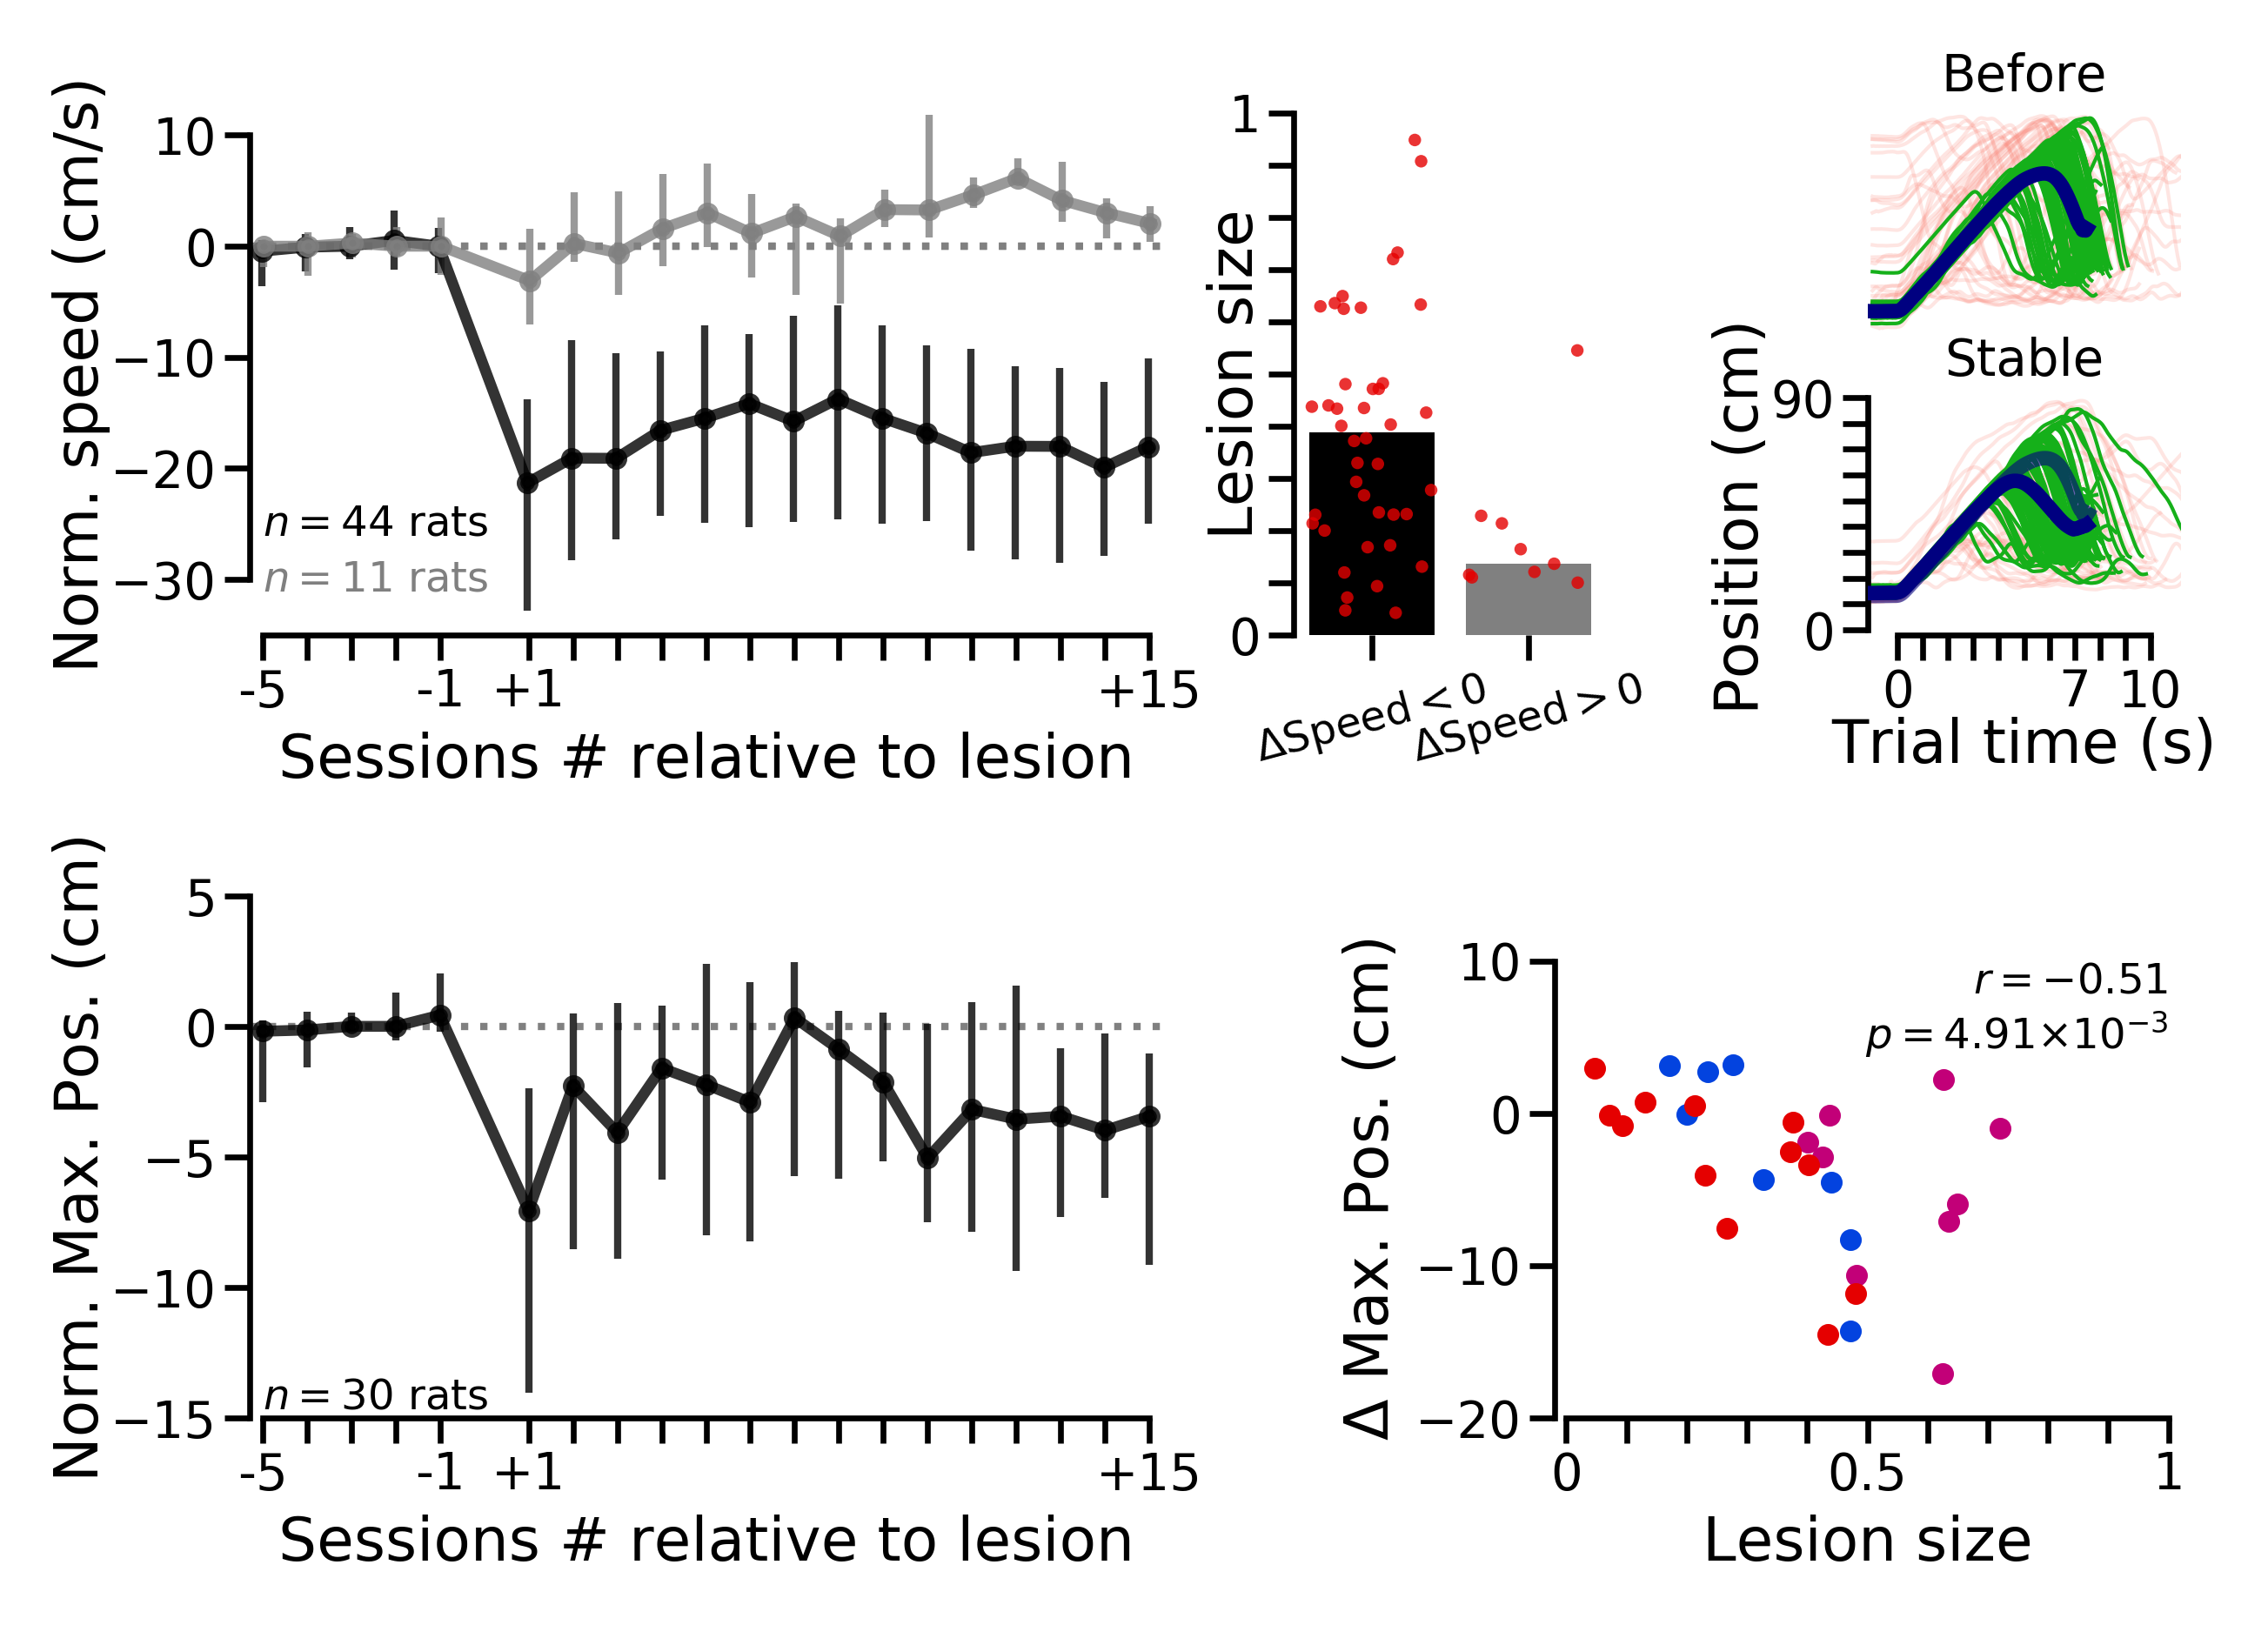

In [25]:
if "__file__" not in dir():
    plt.close('all')
    set_rc_params()
    figsize=(5,2.5)
    fig=plt.figure(figsize=figsize,dpi=600)
    
        

    ##########################################
    # 1: % Models
#     gs1= fig.add_gridspec(nrows=1, ncols=1, left=0, bottom=0.6, right=1, top=1)
#     ax1= fig.add_subplot(gs1[0])
    
#     ax1.xaxis.set_visible(False)
#     ax1.yaxis.set_visible(False)




    
    
    ##########################################
    # 2: Max Pos EXAMPLE
    gs2= fig.add_gridspec(nrows=2, ncols=1, left=.62, bottom=.6, right=.74, top=1, wspace=0)
#     ax2im= fig.add_subplot(gs2[0])
    ax2L = fig.add_subplot(gs2[0])
    ax2R = fig.add_subplot(gs2[1])

    MeanTrajBefore2=plot_trajectories_and_distributions(root, ax2L, sessionBefore2)
    MeanTrajAfter2 =plot_trajectories_and_distributions(root, ax2R, sessionAfter2)
    

    ax2R.plot(np.linspace(-1,len(MeanTrajBefore2)/25-1,len(MeanTrajBefore2)),MeanTrajBefore2,
              color='navy', lw=2, alpha=.6)

    #plotting the image
#     ax2im.clear()
#     plot_animal_image(ax2im,sessionAfter2[:6])
    
    ax2L.set_title('Before',fontsize='x-small')
    ax2R.set_title('Stable',fontsize='x-small')
    
    ax2R.tick_params(bottom=True, left=True, labelbottom=True, labelleft=True)
    ax2R.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
    ax2R.set_xticklabels([0,'','','','','','',7,'','',10])
    ax2R.set_yticks(range(0,91,10))
    ax2R.set_yticklabels([0,'','','','','','','','',90])
    ax2R.spines['bottom'].set_bounds(0,10)
    ax2R.set_xlabel('Trial time (s)',labelpad=0)
    ax2R.set_ylabel('Position (cm)',labelpad=0)
    ax2R.spines['left'].set_bounds(0,90)   
    ax2R.spines['bottom'].set_visible(True)
    ax2R.spines['left'].set_visible(True)



    ##########################################
    # 3: Normalized speed time course
    gs3= fig.add_gridspec(nrows=1, ncols=1, left=0, bottom=.6, right=0.35, top=1)
    ax3= fig.add_subplot(gs3[0])
    
    
    behav3, AllAnimals3=_late_lesion_effect(root, Profiles=Profiles3,badAnimals=[],TaskParamToPlot=TaskParamToPlot1,
                                            preSlice=preSlice3, postSlice=finSlice3)

    goodAnimals3=[animal for i,animal in enumerate(AllAnimals3) if behav3[i]<minSpdReduction3]
    badAnimals3=list(set(AllAnimals3) - set(goodAnimals3))
    
    data3G,_=plot_normalized_time_course(root, ax3, Profiles3,Animals=goodAnimals3,TaskParamToPlot=TaskParamToPlot1,color='k',shift=-.1*.25)
    data3B,_=plot_normalized_time_course(root, ax3, Profiles3,Animals=badAnimals3,TaskParamToPlot=TaskParamToPlot1,color='gray',shift=.1*.25)

    ax3.text(-5,-25,f'$n={data3G.shape[0]}$ rats',
          ha='left',va='center',fontsize='xx-small',color='k')
    ax3.text(-5,-30,f'$n={data3B.shape[0]}$ rats',
          ha='left',va='center',fontsize='xx-small',color='gray')

    ax3.set_yticks(range(-30,11,10))
    ax3.set_ylabel('Norm. speed (cm/s)',labelpad=0)
    ax3.spines['left'].set_bounds(-30,10)
    ax3.set_ylim([-35,12])

    
    
    
    
    ##########################################
    # 5: Normalized Conditional Max Pos time course
    gs5= fig.add_gridspec(nrows=1, ncols=1, left=.0, bottom=0, right=.35, top=.4)
    ax5= fig.add_subplot(gs5[0])
    
    data5,goodAnimals5=plot_normalized_time_course(root, ax5, Profiles3,Animals=goodAnimals3,
                                                   TaskParamToPlot=TaskParamToPlot3,color='k')

    ax5.text(-5,-15,f'$n={data5.shape[0]}$ rats',
          ha='left',va='bottom',fontsize='xx-small',color='k')
    
    ax5.set_ylim([-15,5])
    ax5.set_yticks(range(-15,6,5))
    ax5.set_ylabel('Norm. Max. Pos. (cm)',labelpad=0)
    ax5.spines['left'].set_bounds(-15,5)
    

    
    
    ##########################################
    # 4: % speed correlation
    gs4= fig.add_gridspec(nrows=1, ncols=1, left=0.48, bottom=0, right=.72, top=.35)
    ax4= fig.add_subplot(gs4[0])
  
    
    behav4, size4, animals4=late_lesion_correlation_with_size(root, ax=ax4, Profiles=Profiles3, Animals=goodAnimals5,
                                                              color=ColorCode, TaskParamToPlot=TaskParamToPlot3,
                                                              preSlice=preSlice3, postSlice=finSlice3)
    
    r4,p4=stats.pearsonr(size4, behav4)
    s=f'$r=$'+'$%+.2f$'%(r4)+'\n'+'$p=$'+'{}'.format(SciNote(p4))
    ax4.text(1,10,s, ha='right',va='top', fontsize='xx-small')

    ax4.set_ylim([-20,10])
    ax4.spines['left'].set_bounds(-20,10)
    ax4.set_yticks([-20,-10,0,10])
    ax4.set_ylabel('$\Delta$ Max. Pos. (cm)')
    
    
    
    ##########################################
    # 6: % Lesion size cmparison
    gs6= fig.add_gridspec(nrows=1, ncols=1, left=.4, bottom=0.6, right=0.52, top=1)
    ax6= fig.add_subplot(gs6[0])

    
    plot_group_lesion_bar(goodAnimals3, ax6, x=1, color='k')
    plot_group_lesion_bar(badAnimals3 , ax6, x=2, color='gray')
    
    ax6.set_xlim([.5,2.5])
    ax6.set_xticks([1,2])
    ax6.set_xticklabels(['$\Delta$Speed$<0$','$\Delta$Speed$>0$'], fontsize='xx-small', rotation=15)
    ax6.set_ylim([0,1])
    ax6.set_yticks(np.arange(0,1.01,.1))
    ax6.set_yticklabels([0,'','','','','','','','','',1])
    ax6.set_ylabel('Lesion size',labelpad=-5)
    
    

    
    
    
        
    
#     fig.align_ylabels([axes1[0],axes2[0],axes3[0],axes4[0]])
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     AXES=(axes4[0],ax1,ax2,ax5,ax7,ax8,ax6)
#     OFFX=np.array([.07]*len(AXES))
#     OFFY=np.array([.01]*len(AXES))
#     OFFX[5]=0.03
#     OFFX[[0,1,2,4,6]]=0.05
    
#     add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)
    
    fig.savefig(os.path.join(os.path.dirname(os.getcwd()),'LesionPaper','Figures','MaxPosAnalysis.pdf'),
                format='pdf', bbox_inches='tight')
    
    plt.show()
    plt.close('all')
    matplotlib.rcdefaults()